In [13]:
import shedding
from shedding.model import Model
import numpy as np
import tensorflow as tf
from tensorflow.experimental.numpy import logaddexp as tf_logaddexp
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

Load data

In [26]:
# Load and flatten datasets (the other ones are a bit dodgy)
datasets = shedding.load_datasets([
    'Woelfel2020', 
    'Lui2020', 
    'Wang2020',
    'Han2020',
], 'publications/')
data = shedding.flatten_datasets(datasets, loq_fill_value=-99)
print(f'Number of patients: {data["num_patients"]}')
print(f'Number of patients with one or more positive samples: '
      f'{(data["num_positives_by_patient"] > 0).sum()}')
print(f'Number of samples: {data["num_samples"]}')
print(f'Number of positive samples: {data["positive"].sum()}')

# convert data to tensorflow constants with right data-types
for key in data.keys():
    data[key] = tf.constant(data[key])
    if key == 'num_patients' or key == 'idx':
        data[key] = tf.cast(data[key], tf.int32)
    elif key == 'loadln' or key == 'loqln':
        data[key] = tf.cast(data[key], tf.float32)

# inflated or not
inflated = True

Number of patients: 36
Number of patients with one or more positive samples: 27
Number of samples: 148
Number of positive samples: 104


Model probabilities

In [7]:
# distributions for constructing the prior
Uniform = tfd.Uniform(0, 1)
HalfCauchy = tfd.HalfCauchy(loc=0, scale=1)

def gengamma_lpdf(q, mu, sigma, logx):
    """
    Compute the logarithm of the gengamma pdf.
    """
    a = 1 / (q * q)
    c = q / sigma
    return tf.math.log(c) - tf.math.lgamma(a) + a * tf.math.log(a) + \
        (a * c - 1) * logx - a * (mu * c + tf.math.exp(c * (logx - mu)))


def gengamma_lcdf(q, mu, sigma, logx):
    """
    Compute the logarithm of the gengamma cdf.
    """
    a = 1 / (q * q)
    c = q / sigma
    logarg = c * (logx - mu)
    arg = a * tf.math.exp(logarg)
    cdf = tf.math.igamma(a, arg)
    return tf.math.log(cdf)


def gengamma_loc(q, sigma, log_mean):
    """
    Evaluate the gengamma location parameter for a given shape, scale, 
    and mean.
    """
    a = 1 / q ** 2
    c = q / sigma
    mu = tf.math.log(a) / c + tf.math.lgamma(a) - tf.math.lgamma(a + 1 / c)
    return mu + log_mean


def sample_log_likelihood(parameters):
    """
    Compute the log likelihood for individual samples given patient means.
    """
    
    # unstack the parameters vector
    patient_shape, patient_scale, log_patient_mean, rho, population_shape, population_loc, population_scale = tf.split(parameters, (1, 1, 36, 1, 1, 1, 1), axis=-1)
    
    mu = gengamma_loc(patient_shape, patient_scale, log_patient_mean)
    mu = tf.repeat(mu, data['num_samples_by_patient'], axis=-1)
    lpdf = gengamma_lpdf(patient_shape, mu, patient_scale, data['loadln'])
    lcdf = gengamma_lcdf(patient_shape, mu, patient_scale, data['loqln'])
    return tf.where(data['positive'], lpdf, lcdf)


def patient_log_likelihood(parameters):
    """
    Compute the log likelihood for samples aggregated by patient given
    patient means.
    """
    
    patient_shape, patient_scale, log_patient_mean, rho, population_shape, population_loc, population_scale = tf.split(parameters, (1, 1, 36, 1, 1, 1, 1), axis=-1)

    sll = sample_log_likelihood(parameters)
    pll = tf.stack([tf.math.bincount(data['idx'], sll[i,:], minlength=data['num_patients']) for i in range(sll.shape[0])], axis=0)
    if inflated:        
        # Account for zero inflation
        pll = pll + tf.math.log(rho)
        some_positive = data['num_positives_by_patient'] > 0
        pll = tf.where(some_positive, pll, 
                       tf_logaddexp(pll, tf.math.log1p(-rho)))
        
    return pll


def latent_log_likelihood(parameters):
    """
    Compute the log likelihood for latent parameters given hyperparameters.
    """
    
    patient_shape, patient_scale, log_patient_mean, rho, population_shape, population_loc, population_scale = tf.split(parameters, (1, 1, 36, 1, 1, 1, 1), axis=-1)

    return gengamma_lpdf(
        population_shape, population_loc,
        population_scale, log_patient_mean,
    )


def log_likelihood(parameters):
    """
    Compute the log likelihood, including latent parameters, given
    hyperparameters.
    """
    return patient_log_likelihood(parameters) + \
        latent_log_likelihood(parameters)

def log_prior(parameters):
    
    """
    Compute the log prior for the hyper-parameters.
    """
    
    patient_shape, patient_scale, log_patient_mean, rho, population_shape, population_loc, population_scale = tf.split(parameters, (1, 1, 36, 1, 1, 1, 1), axis=-1)

    return Uniform.log_prob(rho) + HalfCauchy.log_prob(patient_shape) + HalfCauchy.log_prob(patient_scale) + HalfCauchy.log_prob(population_shape) + HalfCauchy.log_prob(population_scale)
    
def log_prob(parameters):
    
    return tf.reduce_sum(log_likelihood(parameters), axis=-1) + tf.squeeze(log_prior(parameters))

Stack the parameters into a single array (this defines the order of the parameters in the 1D flattened vector)

In [10]:
# stack the initial parameters into an initial value
initial_params = {'population_shape': 0.515960576370487,
 'population_loc': 11.5565717463835,
 'population_scale': 3.47310178684614,
 'patient_shape': 0.614518235495056,
 'patient_scale': 3.28016164131799,
 'patient_mean': np.array([1.58109681e+06, 1.62960922e+05, 1.41395408e+06, 4.68819983e+06,
        4.74483035e+04, 6.84407824e+04, 2.67431684e+03, 9.97489948e+04,
        1.49190850e+02, 1.16571517e+04, 4.29331748e+04, 4.63699339e+03,
        7.62192130e+03, 1.15256383e+05, 7.73064475e+04, 1.05531632e+04,
        7.13806977e+05, 2.90353388e+06, 1.50283360e+05, 1.91588787e+04,
        1.32146734e+03, 2.11048180e+06, 1.28815061e+03, 1.84582526e+05,
        1.11418902e+03, 1.86133027e+04, 1.19827476e+03, 2.93958405e+04,
        1.29130768e+04, 1.46401627e+03, 1.18323499e+03, 1.13064256e+03,
        1.25157079e+03, 1.41620152e+05, 1.30795977e+05, 3.37467927e+07]),
  'rho':0.8}

initial_params['log_patient_mean'] = np.log(initial_params['patient_mean'])
order = ['patient_shape', 'patient_scale', 'log_patient_mean', 'rho', 'population_shape', 'population_loc', 'population_scale']
initial_state = tf.cast(tf.concat([np.atleast_1d(initial_params[key]) for key in order], axis=-1), tf.float32)

Affine sampling of full problem

In [17]:
# number of walkers
n_walkers = 500

# number of parameters
n_params = initial_state.shape[0]

# proposal density for initial points
Q = tfd.Normal(loc=initial_state, scale=0.05*initial_state)

# initial states for the walkers
walkers1 = Q.sample(n_walkers)
walkers2 = Q.sample(n_walkers)
current_state1 = tf.Variable(walkers1)
current_state2 = tf.Variable(walkers2)

# initial target log prob
logp_current1 = log_prob(current_state1)
logp_current2 = log_prob(current_state2)

# number of steps to take
n_steps = 100

# chain
chain = [tf.concat([current_state1, current_state2], axis=0)]
accepted = []

# MCMC loop
for step in range(1, n_steps):

    # first set of walkers:

    # proposals
    partners1 = tf.gather(current_state2, np.random.randint(0, n_walkers, n_walkers))
    z1 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
    proposed_state1 = partners1 + tf.transpose(z1*tf.transpose(current_state1 - partners1))

    # target log prob at proposed points
    logp_proposed1 = log_prob(proposed_state1)
    logp_proposed1 = tf.where(tf.math.is_nan(logp_proposed1), tf.ones_like(logp_proposed1)*tf.math.log(0.), logp_proposed1)

    # acceptance probability
    p_accept1 = tf.math.minimum(tf.ones(n_walkers), z1**(n_params-1)*tf.exp(logp_proposed1 - logp_current1) )

    # accept or not
    accept1_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept1)
    accept1 = tf.cast(accept1_, tf.float32)

    # update the state
    current_state1 = tf.transpose( tf.transpose(current_state1)*(1-accept1) + tf.transpose(proposed_state1)*accept1)
    logp_current1 = tf.where(accept1_, logp_proposed1, logp_current1)

    # second set of walkers:

    # proposals
    partners2 = tf.gather(current_state1, np.random.randint(0, n_walkers, n_walkers))
    z2 = 0.5*(tf.random.uniform([n_walkers], minval=0, maxval=1)+1)**2
    proposed_state2 = partners2 + tf.transpose( z2*tf.transpose(current_state2 - partners2))

    # target log prob at proposed points
    logp_proposed2 = log_prob(proposed_state2)
    logp_proposed2 = tf.where(tf.math.is_nan(logp_proposed2), tf.ones_like(logp_proposed2)*tf.math.log(0.), logp_proposed2)

    # acceptance probability
    p_accept2 = tf.math.minimum(tf.ones((n_walkers)), z2**(n_params-1)*tf.exp(logp_proposed2 - logp_current2) )

    # accept or not
    accept2_ = (tf.random.uniform([n_walkers], minval=0, maxval=1) <= p_accept2)
    accept2 = tf.cast(accept2_, tf.float32)

    # update the state
    current_state2 = tf.transpose( tf.transpose(current_state2)*(1-accept2) + tf.transpose(proposed_state2)*accept2)
    logp_current2 = tf.where(accept2_, logp_proposed2, logp_current2)

    # update the chain
    chain.append(tf.concat([current_state1, current_state2], axis=0))
    accepted.append(tf.concat([accept1, accept2], axis=0))

chain = tf.stack(chain)
accepted = tf.stack(accepted)
acceptance_rate = tf.reduce_mean(accepted, axis=0)

Look at the chains

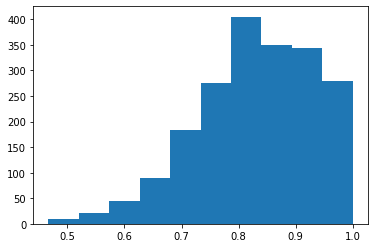

In [25]:
samples = chain[-2:,:,38].numpy().flatten()
plt.hist(samples)
plt.show()

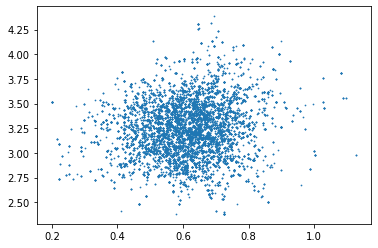

In [27]:
plt.scatter(chain[-10:,:,0].numpy().flatten(), chain[-10:,:,1].numpy().flatten(), s = 0.5)
plt.show()

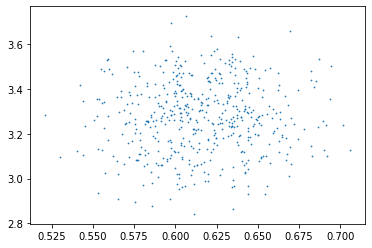

In [22]:
plt.scatter(walkers1[:,0].numpy().flatten(), walkers1[:,1].numpy().flatten(), s = 0.5)
plt.show()